In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#set aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#load the dataset
df = pd.read_csv('UCI_Credit_Card_final.csv')

#display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

#display basic information about the dataset
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,female,university,married,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000.0,female,university,single,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000.0,female,university,single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000.0,female,university,married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000.0,male,university,married,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0



Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  str    
 3   EDUCATION                   29986 non-null  str    
 4   MARRIAGE                    29946 non-null  str    
 5   AGE                         30000 non-null  int64  
 6   PAY_1                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   29850 non-null  float64
 13  BILL_AMT2                  

In [2]:
#summary statistics for numerical features
print("\nSummary Statistics:")
display(df.describe().T)

#check for missing values
print("\nMissing Values Count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

#check for target variable distribution
print("\nTarget Variable Distribution:")
print(df['default.payment.next.month'].value_counts(normalize=True))


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,1.500050e+04,8.660398e+03,1.0,7500.75,15000.5,22500.25,3.000000e+04
LIMIT_BAL,30000.0,1.674843e+05,1.297477e+05,10000.0,50000.00,140000.0,240000.00,1.000000e+06
AGE,30000.0,3.548550e+01,9.217904e+00,21.0,28.00,34.0,41.00,7.900000e+01
PAY_1,30000.0,3.567667e-01,7.605942e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_2,30000.0,3.200333e-01,8.017274e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_3,30000.0,3.040667e-01,7.905890e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_4,30000.0,2.587667e-01,7.611126e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_5,30000.0,2.215000e-01,7.177197e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_6,30000.0,2.265667e-01,7.154378e-01,0.0,0.00,0.0,0.00,8.000000e+00
BILL_AMT1,29850.0,5.124887e+04,7.365806e+04,-165580.0,3570.25,22414.0,67190.00,9.645110e+05



Missing Values Count:
EDUCATION                      14
MARRIAGE                       54
BILL_AMT1                     150
BILL_AMT2                     150
BILL_AMT3                     150
BILL_AMT4                     150
BILL_AMT5                     150
BILL_AMT6                     150
default.payment.next.month     20
dtype: int64

Target Variable Distribution:
default.payment.next.month
0.0    0.778719
1.0    0.221281
Name: proportion, dtype: float64


C:\Users\allam\AppData\Local\Temp\ipykernel_17156\2742115387.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default.payment.next.month', data=df, palette='viridis')


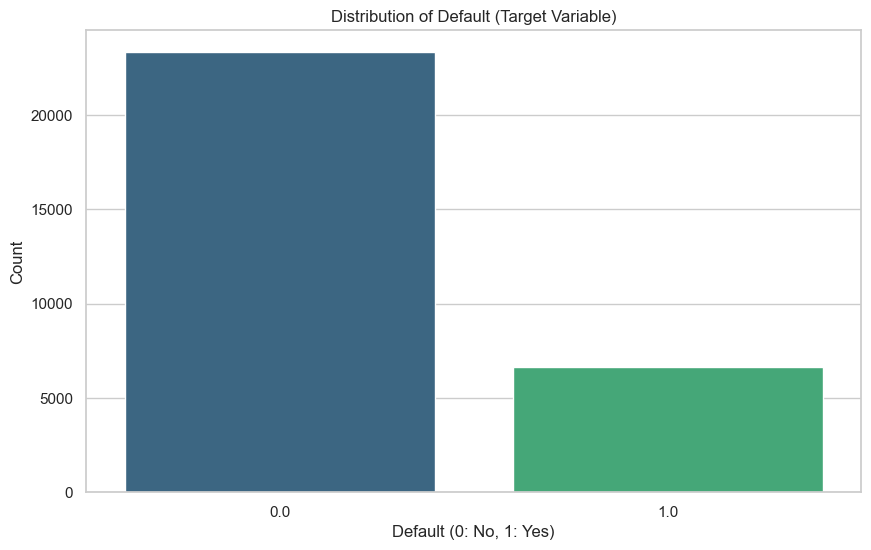

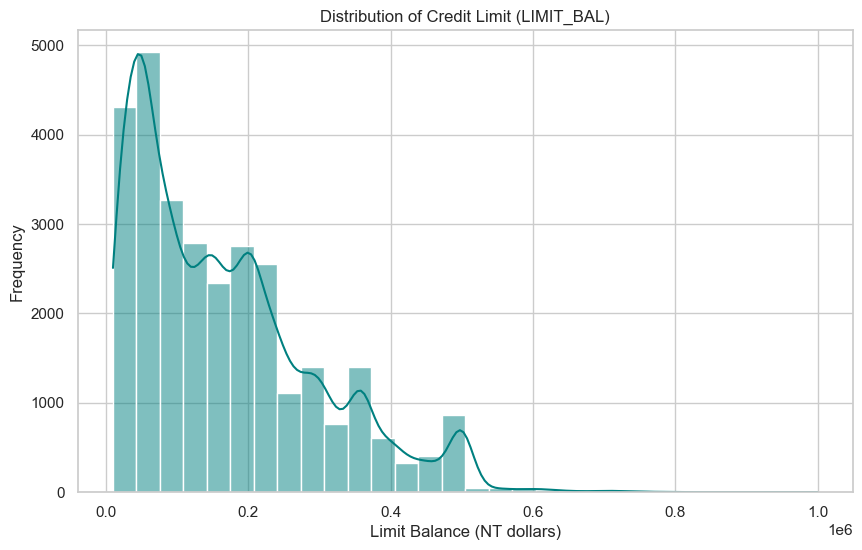

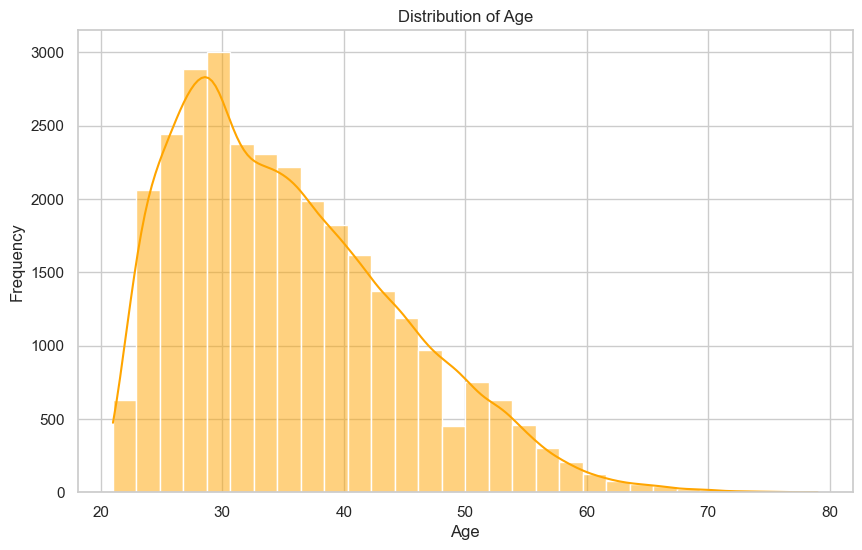

In [3]:
#visualize the target variable balance
plt.figure()
sns.countplot(x='default.payment.next.month', data=df, palette='viridis')
plt.title('Distribution of Default (Target Variable)')
plt.xlabel('Default (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

#visualize the distribution of Credit Limit (LIMIT_BAL)
plt.figure()
sns.histplot(df['LIMIT_BAL'], bins=30, kde=True, color='teal')
plt.title('Distribution of Credit Limit (LIMIT_BAL)')
plt.xlabel('Limit Balance (NT dollars)')
plt.ylabel('Frequency')
plt.show()

#visualize Age distribution
plt.figure()
sns.histplot(df['AGE'], bins=30, kde=True, color='orange')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()